# Insert your subscription key

In [1]:
SUBSCRIPTION_KEY = 'YOUR BING API SUBSCRIPTION KEY'

# Global Variables

In [2]:
_DATA = 'data/'
BASE_URI = 'https://api.cognitive.microsoft.com/bing/v7.0/images/visualsearch'

# Libraries

In [3]:
from matplotlib import pyplot as plt
from urllib import request
import requests, json
import cv2

# Functions

In [4]:
def print_json(obj):
    """Print the object as json"""
    print(json.dumps(obj, sort_keys=True, indent=2, separators=(',', ': ')))

In [5]:
def print_figure(img, fig_size=(8,8), fig_title=None):
    plt.figure(figsize=fig_size)
    if fig_title!=None:
        plt.title(fig_title, fontdict={'fontsize':20})
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
def calculate_bounding_box_coordinates(float_top_left, float_bottom_right, shape):
    int_top_left = (int(shape[1]*float_top_left['x']),int(shape[0]*float_top_left['y']))
    int_bottom_right = (int(shape[1]*float_bottom_right['x']),int(shape[0]*float_bottom_right['y']))
    return(int_top_left, int_bottom_right)

In [7]:
def draw_bounding_boxes(img, visual_search_json, debug=False):
    img=img.copy()
    for element in visual_search_json['tags']:
        for actions in element['actions']:
            if actions['actionType'] == 'ProductVisualSearch' and 'boundingBox' in element:
                top_left, bottom_right = calculate_bounding_box_coordinates(element['boundingBox']['queryRectangle']['topLeft'],\
                                                       element['boundingBox']['queryRectangle']['bottomRight'],\
                                                       img.shape)
                cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)    
                print(element['displayName'])
                if debug:
                    print_json(element['boundingBox']['displayRectangle'])
                    print("\n")
    print_figure(img)

In [8]:
def find_product_visual_search(img, visual_search_json, debug=False):
    products_visual_search = {}
    products_visual_search['productName'] = []
    products_visual_search['boundingBox'] = []
    for element in visual_search_json['tags']:
        for actions in element['actions']:
            if actions['actionType'] == 'ProductVisualSearch' and 'boundingBox' in element:
                products_visual_search['boundingBox']\
                    .append(calculate_bounding_box_coordinates(\
                        element['boundingBox']['queryRectangle']['topLeft'],\
                        element['boundingBox']['queryRectangle']['bottomRight'],\
                        img.shape)\
                    )
                products_visual_search['productName'].append(element['displayName'])
                if debug:
                    print_json(element['boundingBox']['displayRectangle'])
                    print("\n")
    return products_visual_search

In [9]:
def draw_bounding_boxes(img, list_bounding_box, debug=False):
    img=img.copy()
    for bbox in list_bounding_box:
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 2)    
    print_figure(img)

In [10]:
def crop_image_products(img, products_visual_search, print_products = True):
    products_visual_search['croppedProduct'] = []
    for idx, ((top_left_x, top_left_y), (bottom_right_x, bottom_right_y)) in enumerate(products_visual_search['boundingBox']):
        img_product = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x, :].copy()
        products_visual_search['croppedProduct'].append(img_product)
        if print_products:
            print_figure(img_product, fig_title=products_visual_search['productName'][idx])
    return products_visual_search

In [11]:
def print_detected_products_from_url(img_url, print_raw=True, print_bbox=True, print_products=True):
    #SAVING FILE
    file_path = _DATA+'temp.jpg'
    f = open(file_path, 'wb')
    f.write(request.urlopen(img_url).read())
    f.close()
    img = plt.imread(file_path)
    
    #API CALL
    HEADERS = {'Ocp-Apim-Subscription-Key': SUBSCRIPTION_KEY}

    imagePath = file_path

    file = {'image' : ('myfile', open(file_path, 'rb'))}
    response = requests.post(BASE_URI, headers=HEADERS, files=file)
    response.raise_for_status()
    
    #EXTRACTING PRODUCTS FROM VISUAL SEARCH RESPONSE
    products = find_product_visual_search(img, response.json())
    if print_raw:
        print("Raw Image")
        print_figure(img)
    
    if print_bbox:
        print("Image w/ Bounding Box")
        draw_bounding_boxes(img, products['boundingBox'])
        
    products = crop_image_products(img, products, print_products)
    
    return products
    

# Code Demo

Raw Image


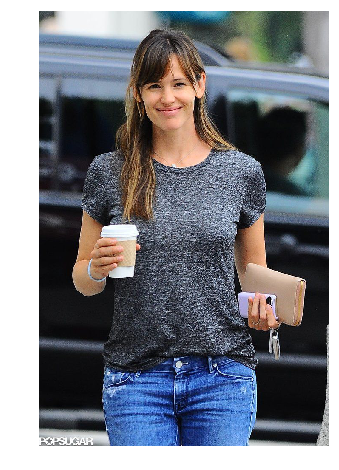

Image w/ Bounding Box


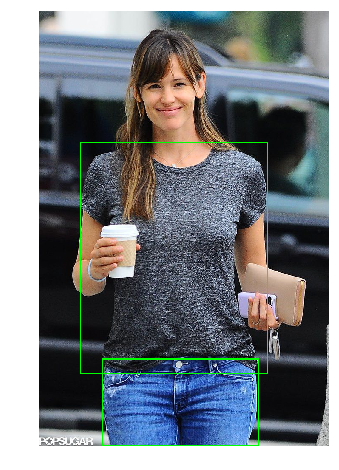

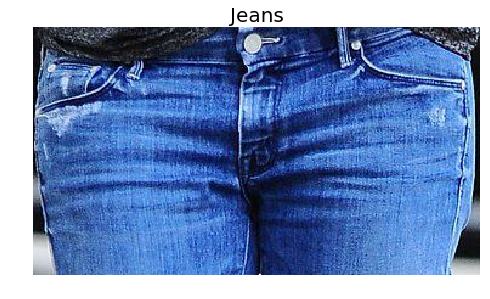

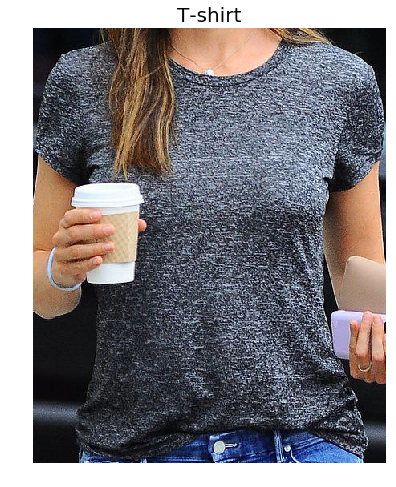

In [12]:
img_url = u'https://i.pinimg.com/originals/f2/cb/33/f2cb332136712d6523a0fff11ce01fa2.jpg'
result = print_detected_products_from_url(img_url)

Raw Image


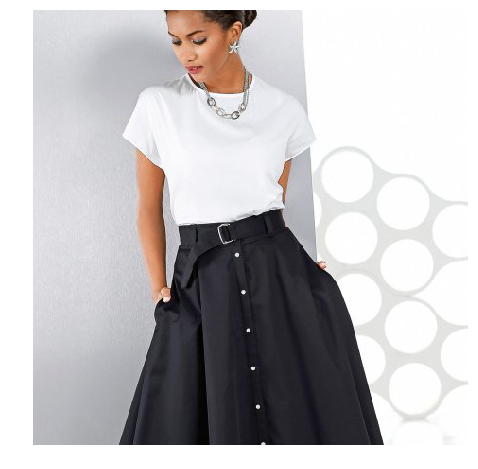

Image w/ Bounding Box


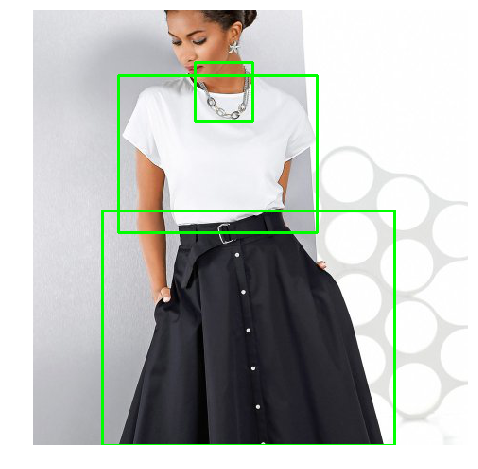

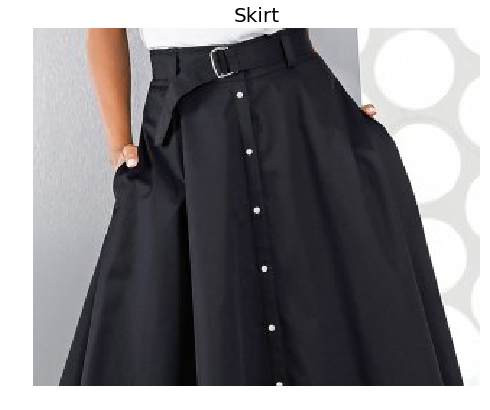

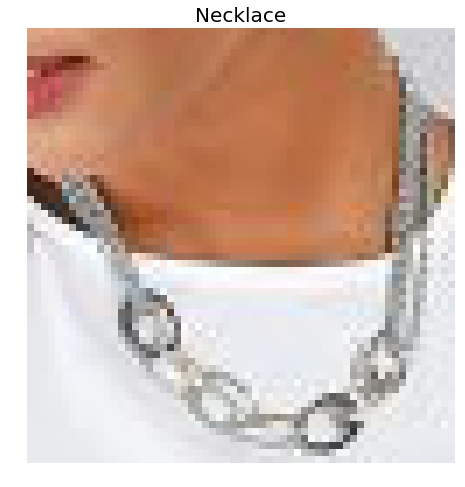

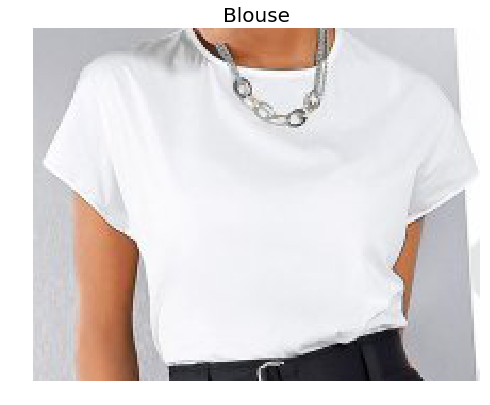

In [13]:
img_url = u'https://image01.bonprix.de/api/s,x,460,y,460/teaser/homepage/181-kanalseite-brasilien-moda-feminina/kw15roecke-729539.jpg?h=Z8V7PnBtks0AX71CGkf75BE0eS1fVQrsEQ+qkjYfR1s='
result = print_detected_products_from_url(img_url)

# Step-By-Step

In [14]:
file_path = _DATA+'temp.jpg'
f = open(file_path, 'wb')
f.write(request.urlopen(img_url).read())
f.close()

In [15]:
img = plt.imread(file_path)

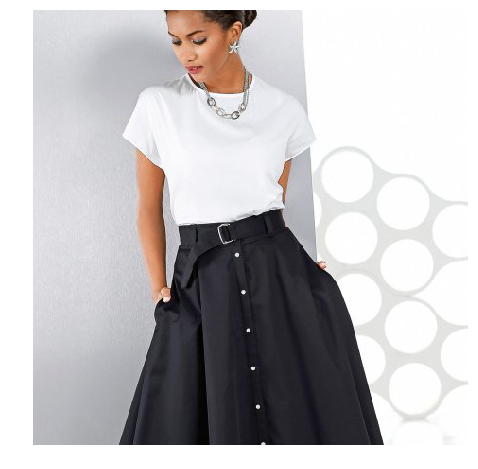

In [16]:
print_figure(img)

In [17]:
HEADERS = {'Ocp-Apim-Subscription-Key': SUBSCRIPTION_KEY}

imagePath = file_path

file = {'image' : ('myfile', open(file_path, 'rb'))}

In [18]:
response = requests.post(BASE_URI, headers=HEADERS, files=file)
response.raise_for_status()

In [19]:
products = find_product_visual_search(img, response.json())

In [20]:
print(products['productName'])

['Skirt', 'Necklace', 'Blouse']


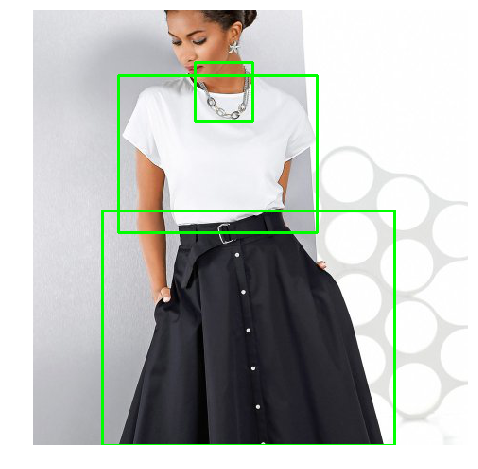

In [21]:
draw_bounding_boxes(img, products['boundingBox'])

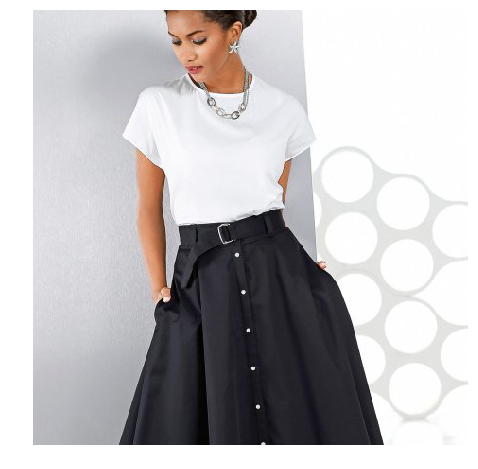

In [22]:
print_figure(img)

In [23]:
products = crop_image_products(img, products, False)

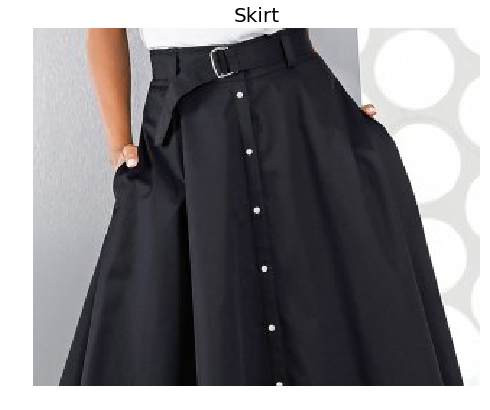

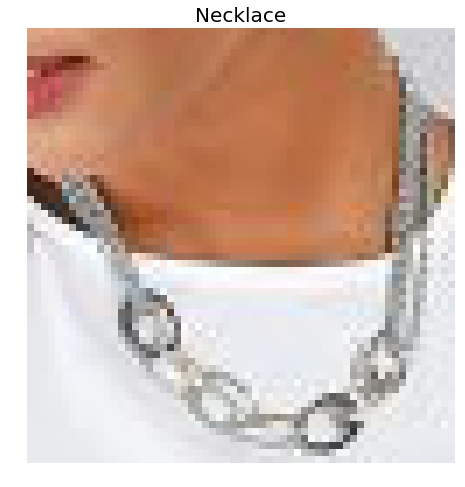

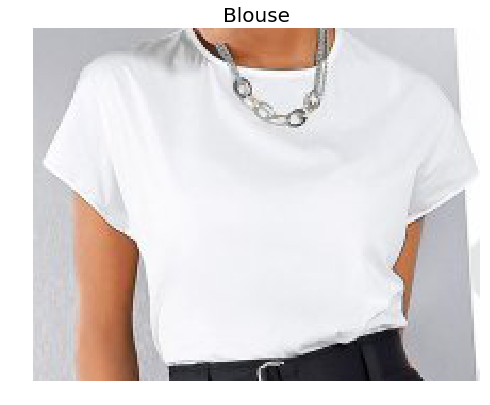

In [24]:
for idx, p in enumerate(products['croppedProduct']):
    print_figure(p, fig_title=products['productName'][idx])